# Name: Srinibas Masanta
# Roll Number: 202318054

##1. Setup and Data Preparation

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e4f5e200dd8b2b8a1454c24240812dc5123f60cfb8b23030bdf9d575d49c2d05
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("OnlineNewsPopularity") \
    .getOrCreate()

# Fetch dataset
df = fetch_ucirepo(id=332)

# Print metadata
print("Metadata:")
print(df.metadata)

# Print variable information
print("\nVariable Information:")
df.variables

Metadata:
{'uci_id': 332, 'name': 'Online News Popularity', 'repository_url': 'https://archive.ics.uci.edu/dataset/332/online+news+popularity', 'data_url': 'https://archive.ics.uci.edu/static/public/332/data.csv', 'abstract': 'This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 39797, 'num_features': 58, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': [' shares'], 'index_col': ['url'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5NS3V', 'creators': ['Kelwin Fernandes', 'Pedro Vinagre', 'Paulo Cortez', 'Pedro Sernadela'], 'intro_paper': {'title': 'A Proactive Intelligent Decision Support System fo

,name,role,type,demographic,description,units,missing_values
0,url,ID,Categorical,None,None,None,no
1,timedelta,Other,Continuous,None,None,None,no
2,n_tokens_title,Feature,Continuous,None,None,None,no
3,n_tokens_content,Feature,Continuous,None,None,None,no
4,n_unique_tokens,Feature,Continuous,None,None,None,no
...,...,...,...,...,...,...,...
56,title_subjectivity,Feature,Continuous,None,None,None,no
57,title_sentiment_polarity,Feature,Continuous,None,None,None,no
58,abs_title_subjectivity,Feature,Continuous,None,None,None,no
59,abs_title_sentiment_polarity,Feature,Continuous,None,None,None,no


In [4]:
import pandas as pd

# Convert Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(pd.concat([df.data.features, df.data.targets], axis=1))

In [5]:
# Show the first few rows of the DataFrame
df_spark.show(10)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [6]:
# Show schema
df_spark.printSchema()

root
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: double (nullable = true)
 |--  kw_avg_min: double (nullable = true)
 |--  kw_mi

In [7]:
# Show count
df_spark.count()

39644

In [8]:
df_spark.describe().show()

+-------+------------------+-----------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------------+---------------------------+-----------

## 2. Data Preprocessing

In [9]:
# Drop rows with missing values
df_spark = df_spark.dropna()

# Drop URL column
df_spark = df_spark.drop("url")

In [10]:
from pyspark.sql.functions import when

# Convert column names to remove leading and trailing whitespaces
df_spark = df_spark.toDF(*(c.strip() for c in df_spark.columns))

# Calculate the median value of the shares column
median_shares = df_spark.approxQuantile("shares", [0.5], 0.001)[0]

# Create a new column for popularity based on the threshold
df_spark = df_spark.withColumn("popularity", when(df_spark["shares"] >= median_shares, 1).otherwise(0))

# Drop the original shares column
df_spark = df_spark.drop("shares")

# Show the first 5 rows after preprocessing
df_spark.show(5)

+--------------+----------------+---------------+----------------+------------------------+---------+--------------+--------+----------+--------------------+------------+-------------------------+-----------------------------+-------------------+----------------------+--------------------+---------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------------------------+-------------------------+--------------------------+-----------------+------------------+--------------------+-------------------+-----------------+-------------------+-----------------+----------+---------------+---------------+---------------+---------------+---------------+-------------------+-------------------------+--------------------------+--------------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------

##3. Exploratory Data Analysis (EDA)

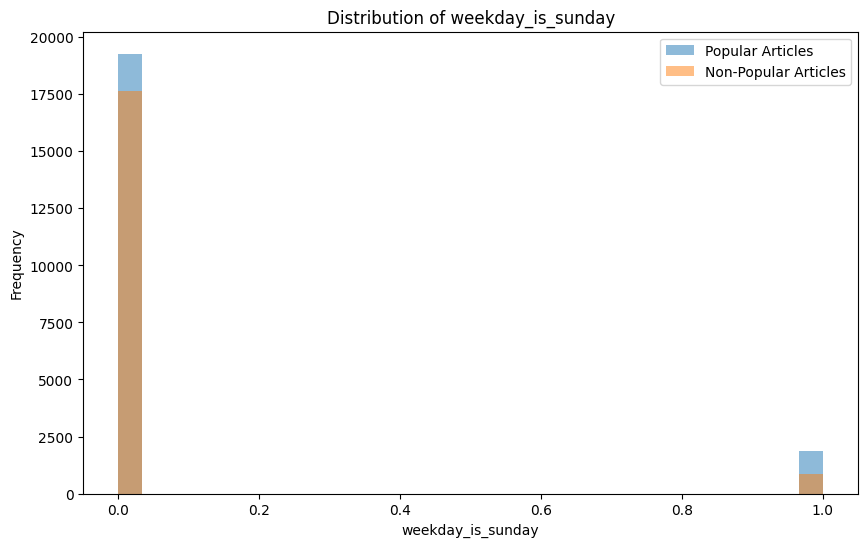

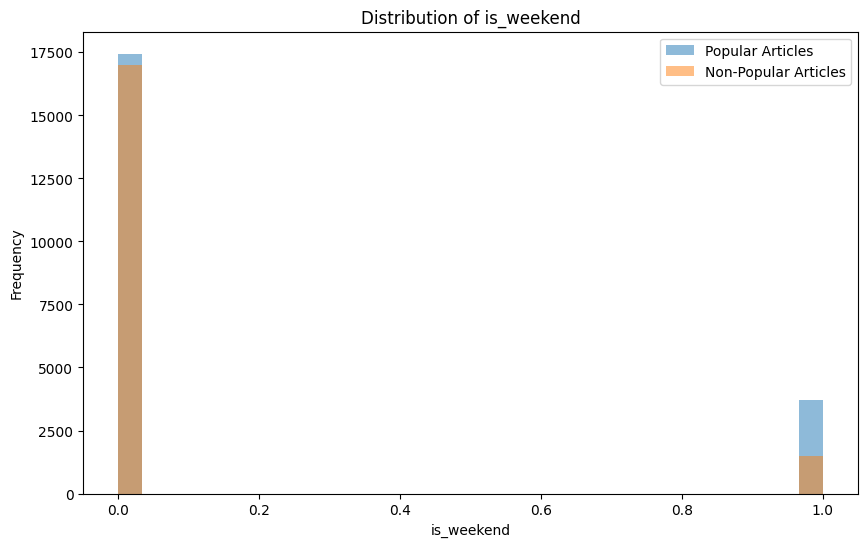

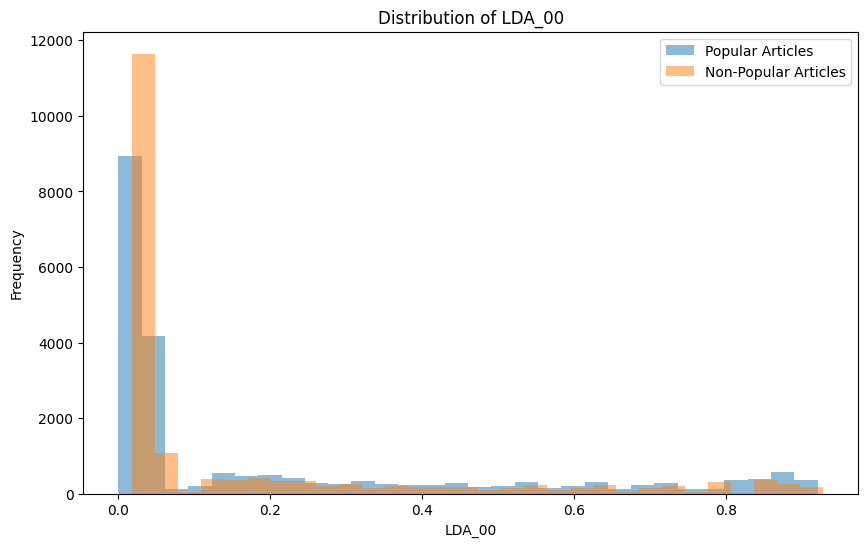

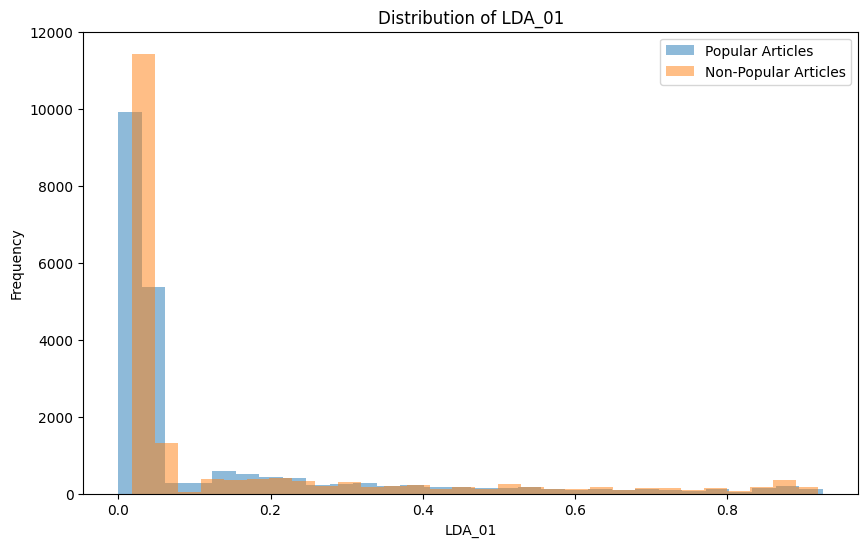

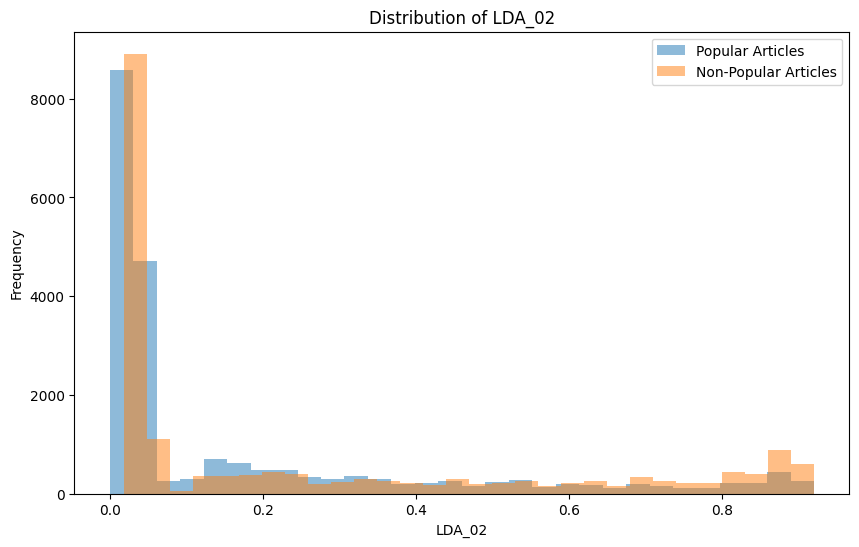

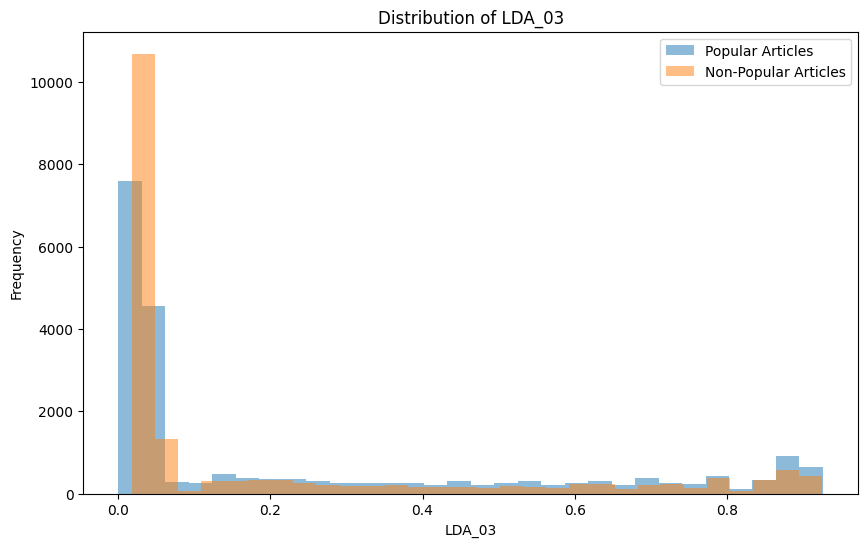

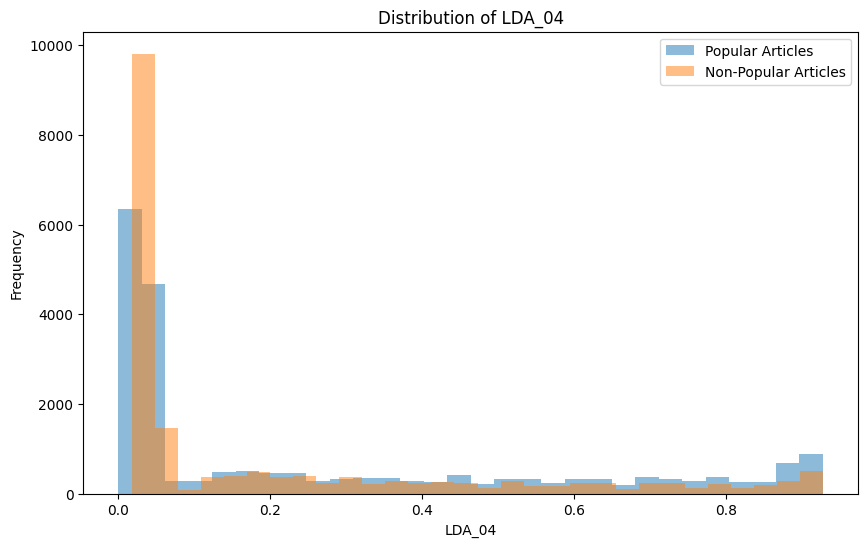

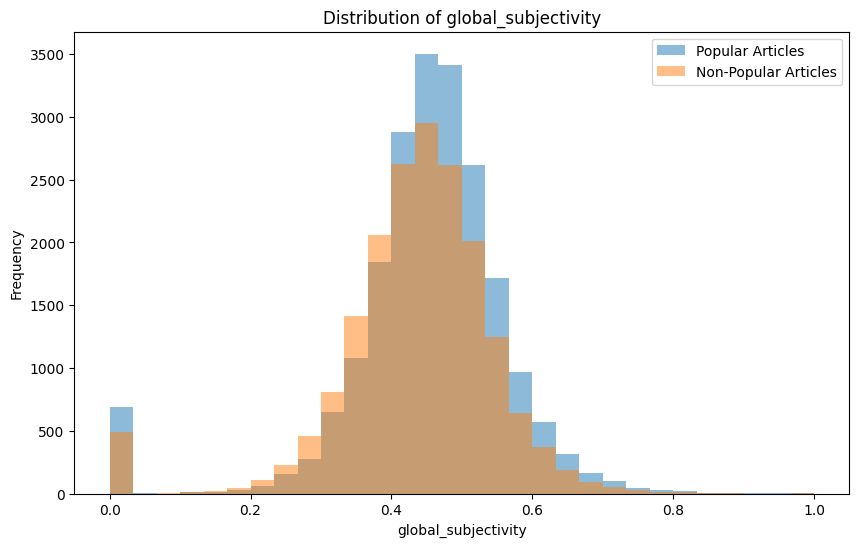

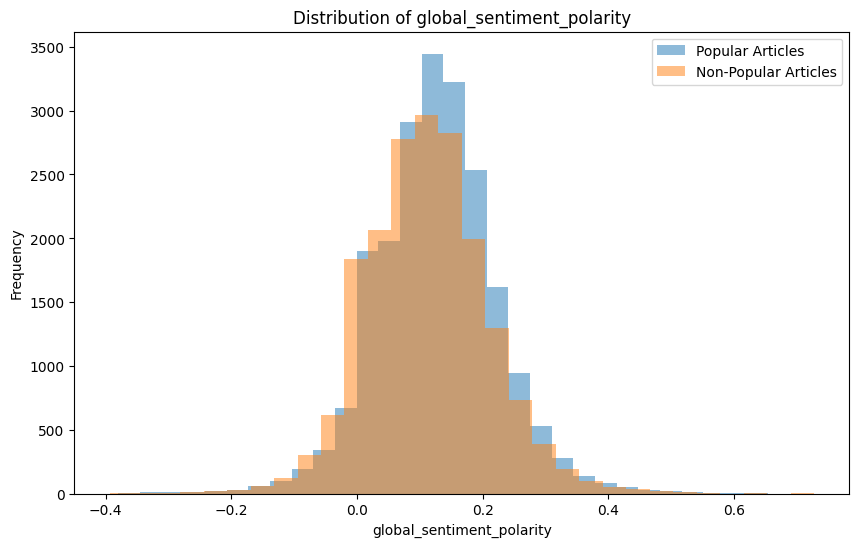

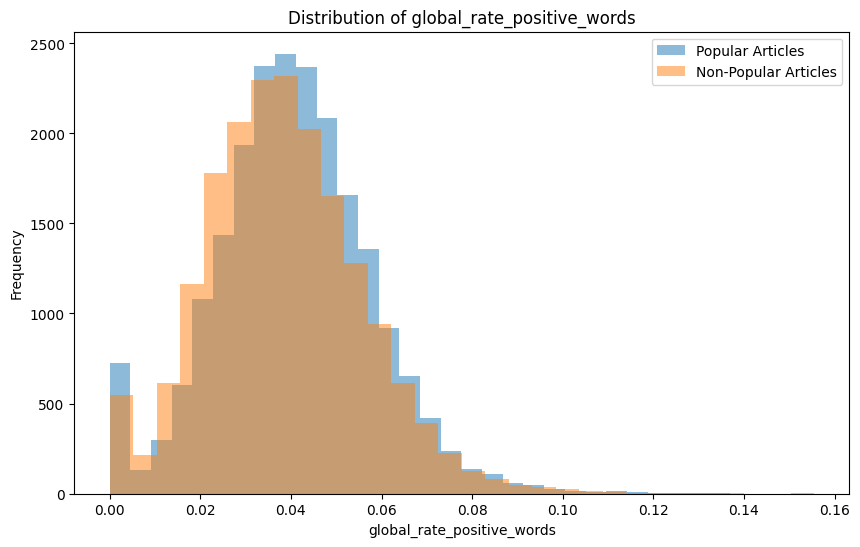

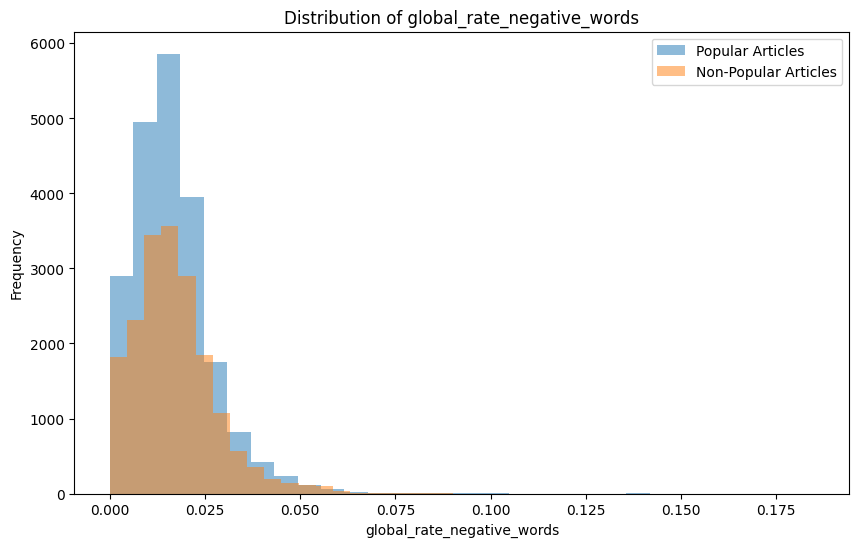

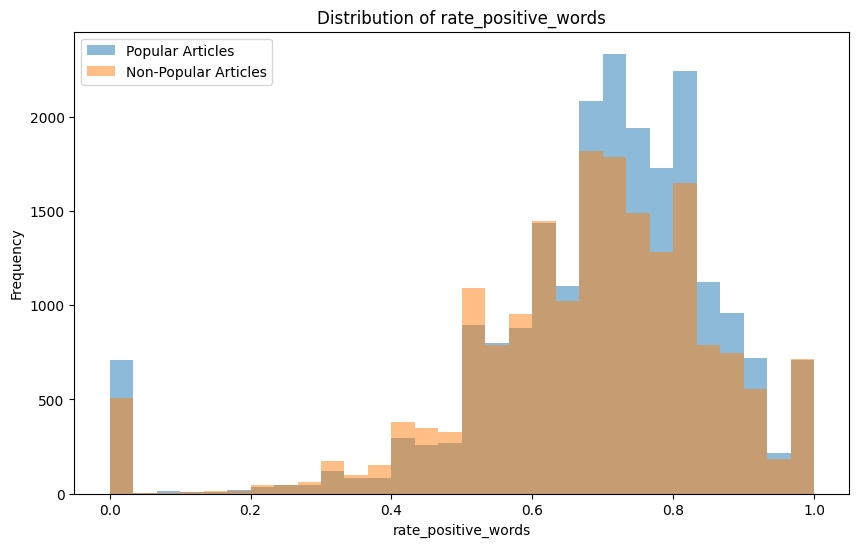

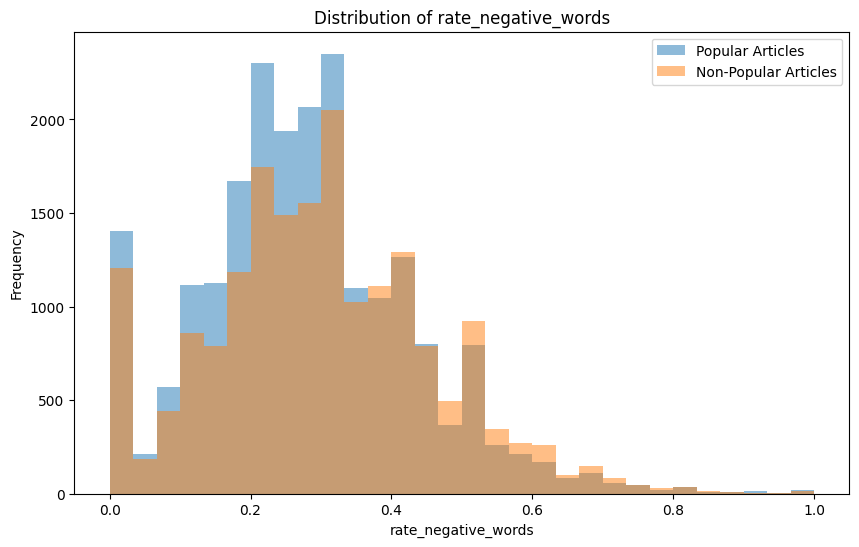

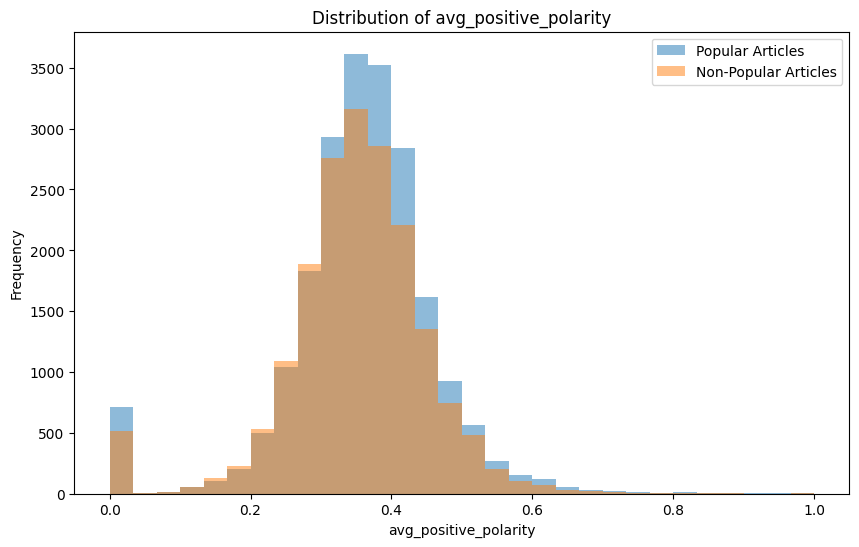

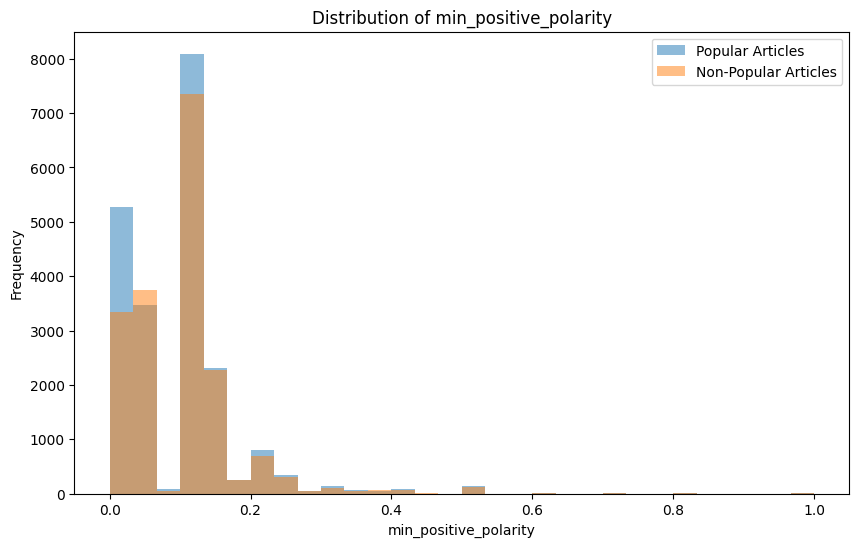

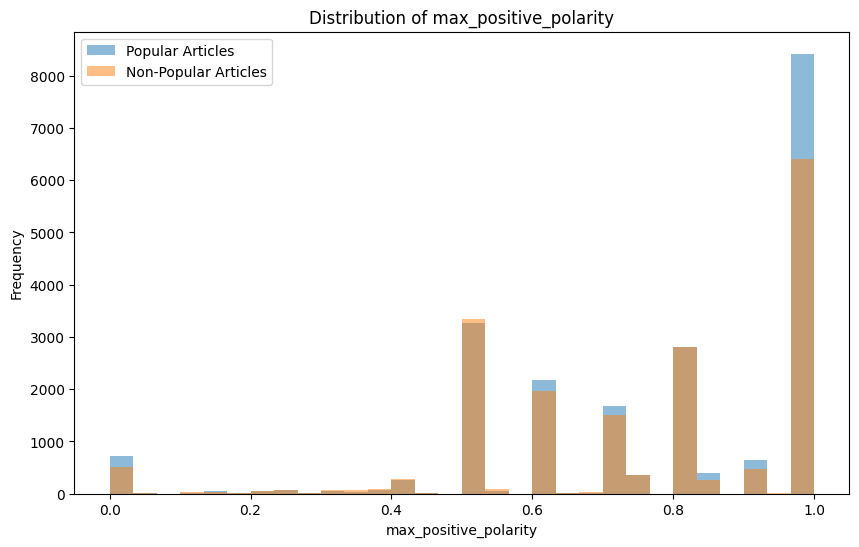

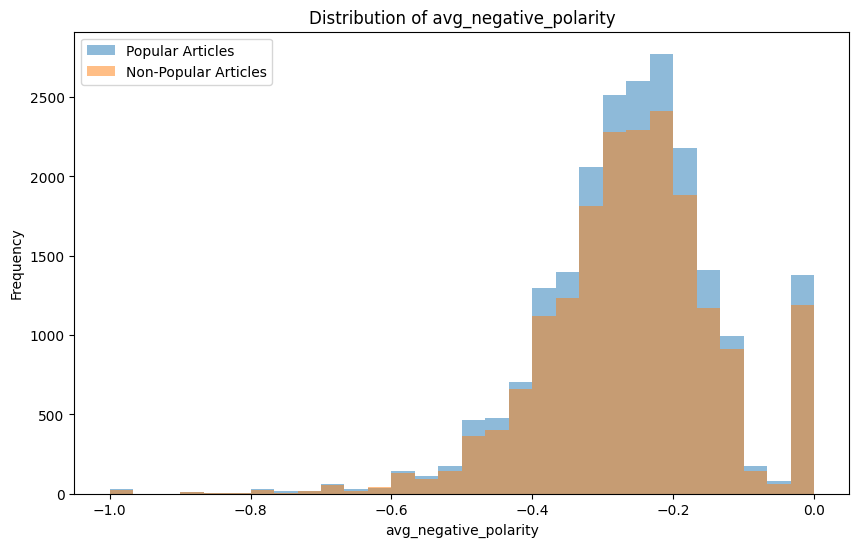

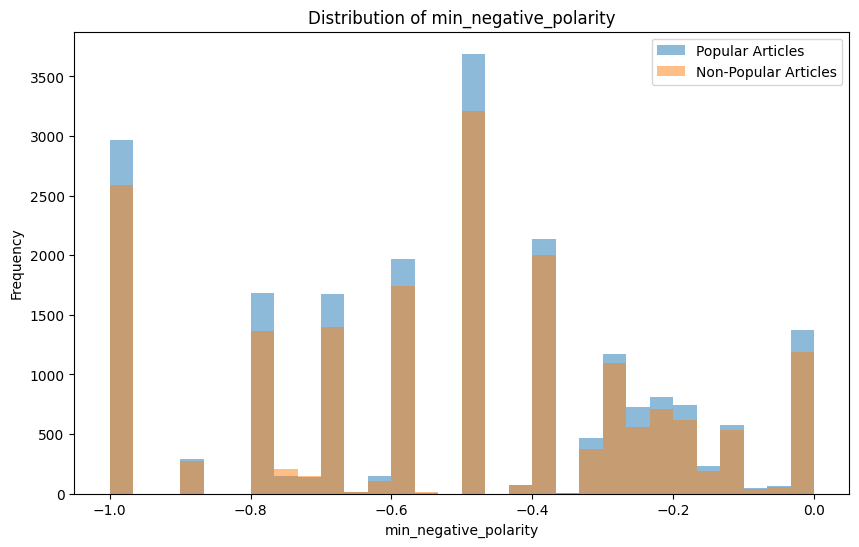

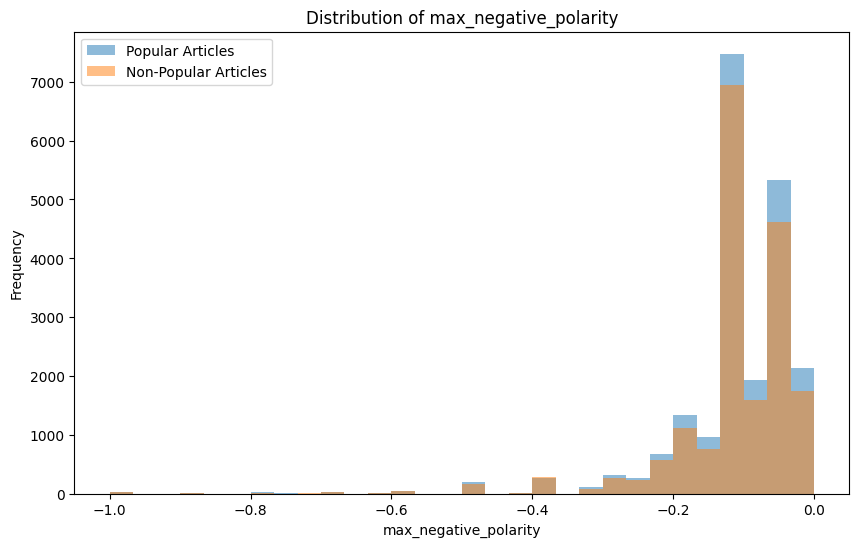

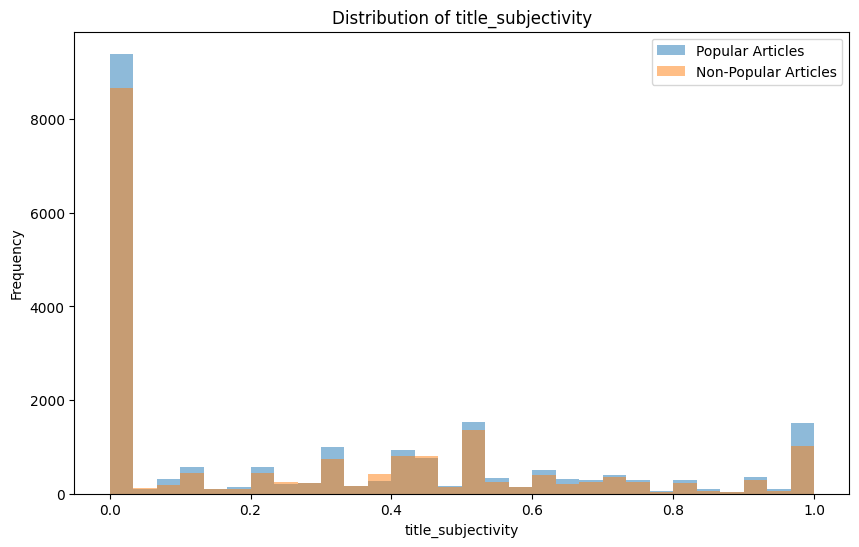

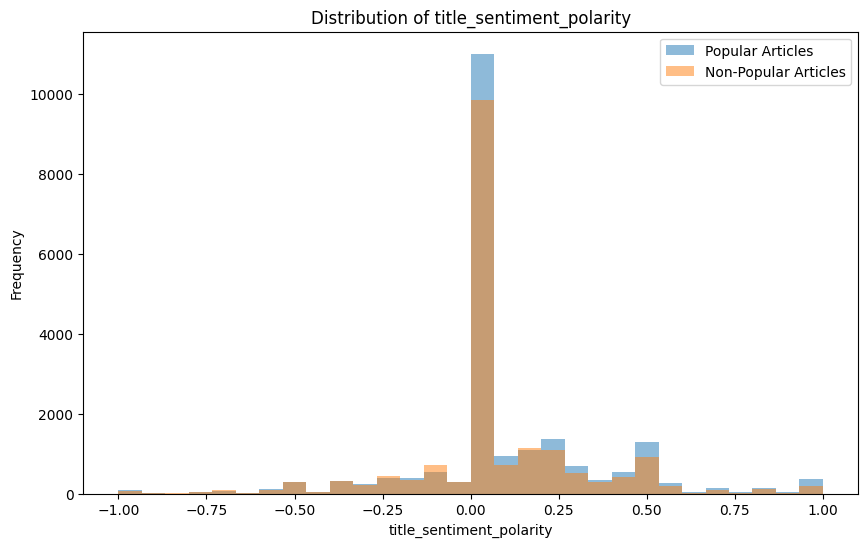

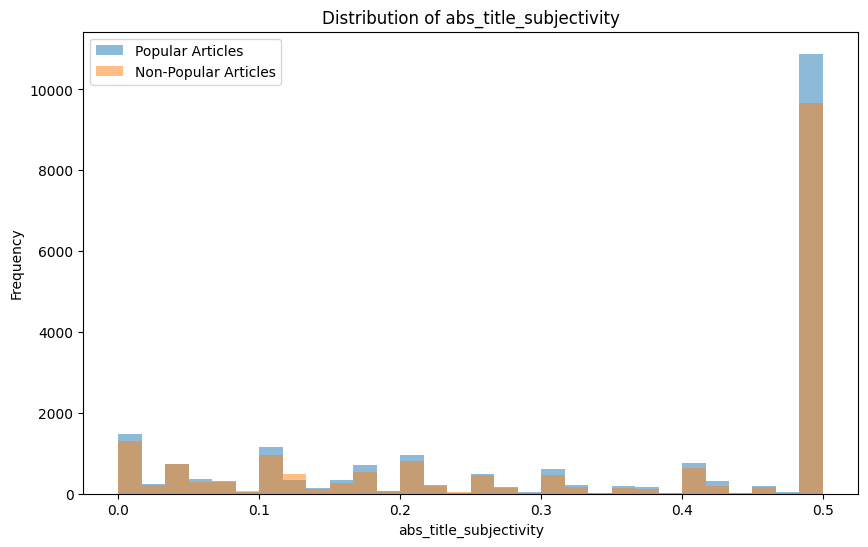

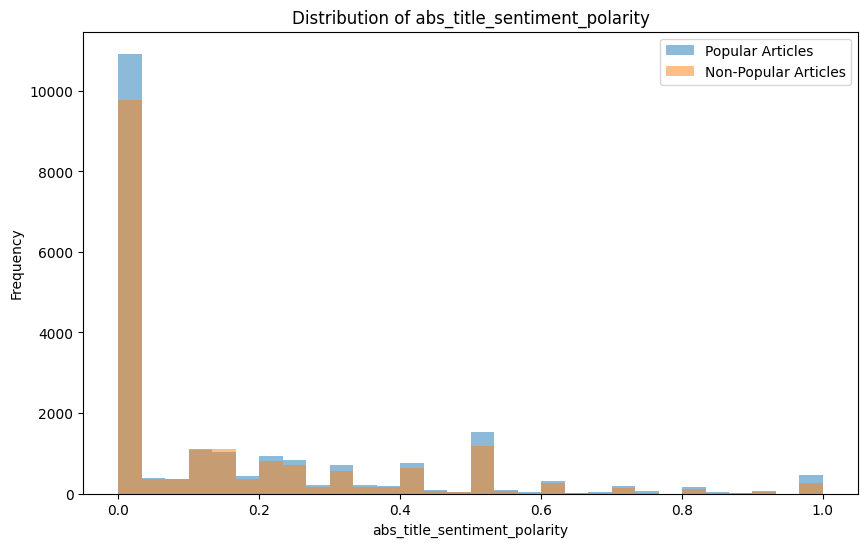

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter popular and non-popular articles
popular_articles = df_spark.filter(df_spark["popularity"] == 1)
non_popular_articles = df_spark.filter(df_spark["popularity"] == 0)

# Summary statistics
popular_summary = popular_articles.describe().toPandas().transpose()
non_popular_summary = non_popular_articles.describe().toPandas().transpose()

# Plot histogram function
def plot_histogram(feature_name, popular_data, non_popular_data):
    plt.figure(figsize=(10, 6))
    plt.hist(popular_data.select(feature_name).rdd.flatMap(lambda x: x).collect(), bins=30, alpha=0.5, label='Popular Articles')
    plt.hist(non_popular_data.select(feature_name).rdd.flatMap(lambda x: x).collect(), bins=30, alpha=0.5, label='Non-Popular Articles')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

# Features to plot
features_to_plot = [
    'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
    'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words',
    'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
    'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity',
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

# Plot histograms for each feature
for feature in features_to_plot:
    plot_histogram(feature, popular_articles, non_popular_articles)

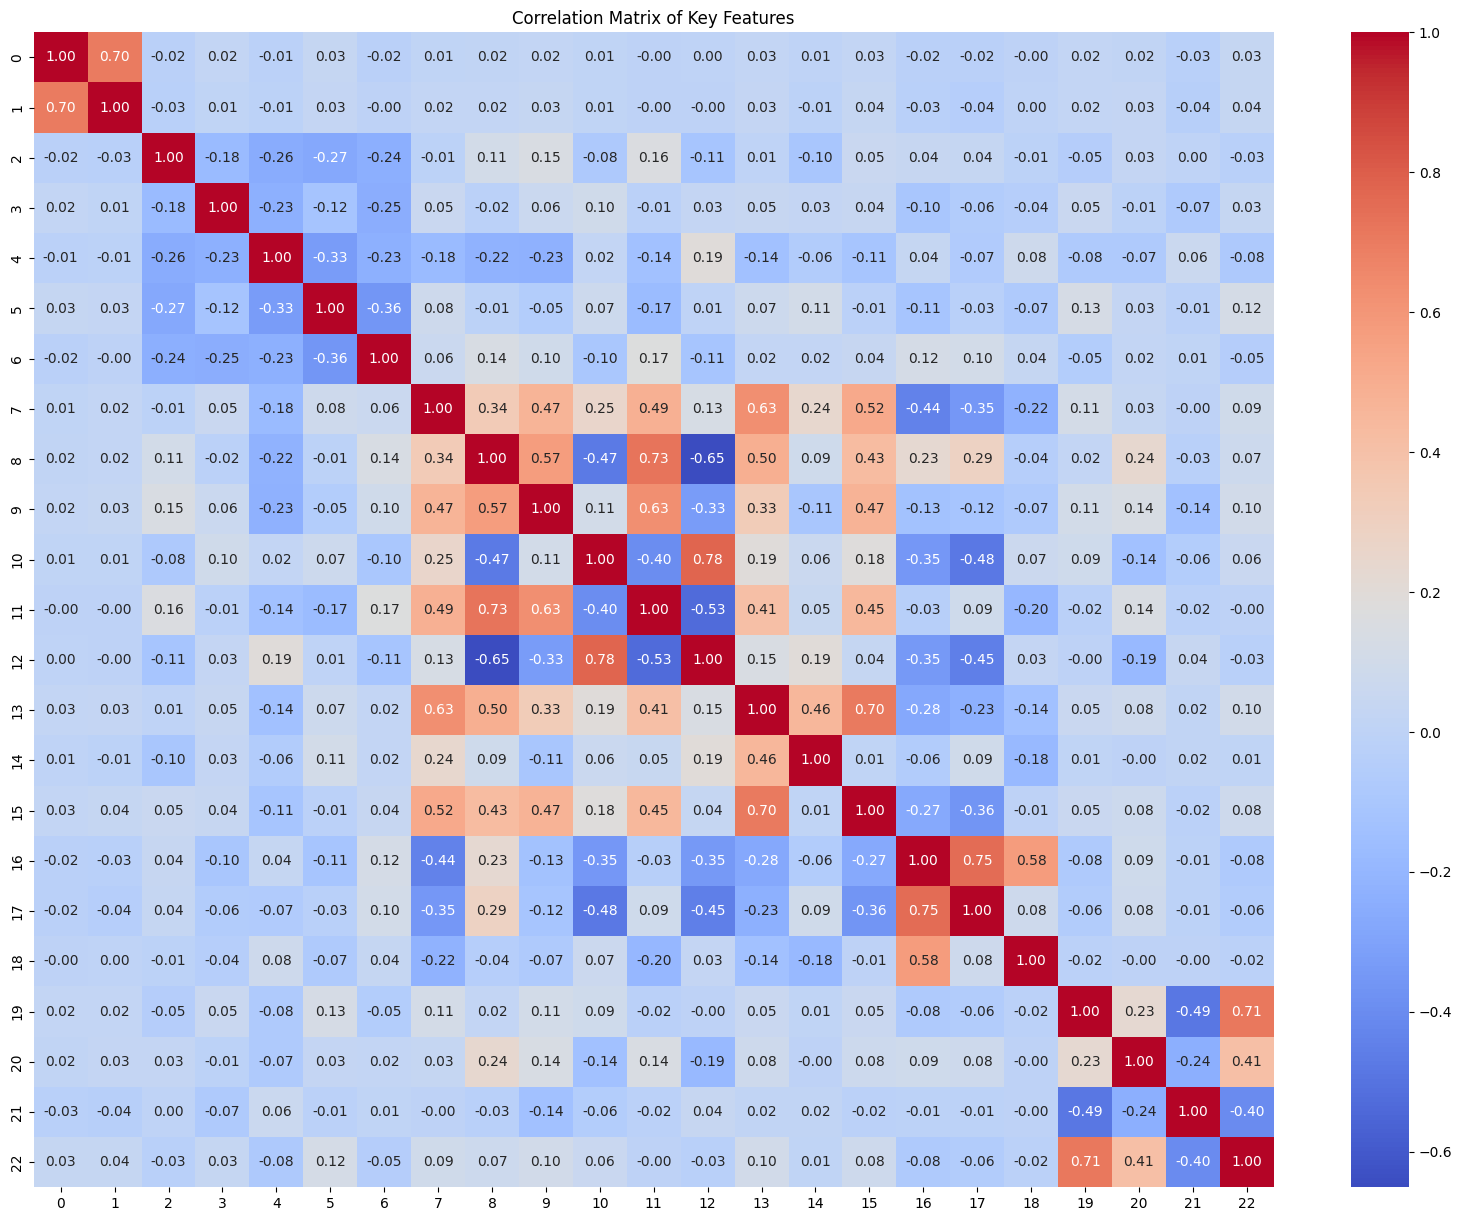

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Define numerical features
numerical_features = [
    'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
    'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words',
    'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
    'max_positive_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity',
    'title_subjectivity', 'title_sentiment_polarity', 'abs_title_subjectivity', 'abs_title_sentiment_polarity'
]

# Vector assembler
vector_assembler = VectorAssembler(inputCols=numerical_features, outputCol="features")
assembled_data = vector_assembler.transform(df_spark).select("features")

# Correlation matrix
correlation_matrix = Correlation.corr(assembled_data, "features").head()

# Convert correlation matrix to array
correlation_array = correlation_matrix[0].toArray()

# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_array, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Features")
plt.show()

## 4. Feature Engineering

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when

# Create new feature: article length category
df_spark = df_spark.withColumn("article_length_category",
                       when(col("n_tokens_content") < 500, "Short")
                       .when((col("n_tokens_content") >= 500) & (col("n_tokens_content") < 1000), "Medium")
                       .otherwise("Long"))

# Create new feature: weekday of publication
df_spark = df_spark.withColumn("weekday_of_publication",
                       when(col("weekday_is_monday") == 1, "Monday")
                       .when(col("weekday_is_tuesday") == 1, "Tuesday")
                       .when(col("weekday_is_wednesday") == 1, "Wednesday")
                       .when(col("weekday_is_thursday") == 1, "Thursday")
                       .when(col("weekday_is_friday") == 1, "Friday")
                       .when(col("weekday_is_saturday") == 1, "Saturday")
                       .when(col("weekday_is_sunday") == 1, "Sunday")
                       .otherwise("Unknown"))

# Define feature columns (excluding target and newly created features)
feature_columns = [col_name for col_name in df_spark.columns if col_name not in ["popularity", "article_length_category", "weekday_of_publication"]]

# VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="combined_features")

# Transforming the DataFrame to combine feature columns into a single vector column
df_spark = assembler.transform(df_spark)

# Show the first 5 rows with features and target
df_spark.select("combined_features", "popularity").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|combined_features                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## 5. Model Building

### Logistic Regression

In [14]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Split the dataset into training and testing sets (80:20 ratio)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Define the logistic regression model
lr = LogisticRegression(featuresCol="combined_features", labelCol="popularity", maxIter=10)

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol="popularity", metricName="areaUnderROC")

# Train the logistic regression model using the training data
model = lr.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

# Evaluate the model using the evaluator
evaluation_result = evaluator.evaluate(predictions)

# Display the evaluation result
print("Area Under ROC:", evaluation_result)

Area Under ROC: 0.7011255303214402


### Random Forest

In [19]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# Split the dataset into training and testing sets (80:20 ratio)
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest classifier
rf = RandomForestClassifier(featuresCol="combined_features", labelCol="popularity", seed=42)

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(labelCol="popularity", metricName="areaUnderROC")

# Train the Random Forest classifier using the training data
model = rf.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

# Evaluate the model using the evaluator
evaluation_result = evaluator.evaluate(predictions)

# Display the evaluation result
print("Area Under ROC:", evaluation_result)

Area Under ROC: 0.6980917204315392


##6. Model Evaluation

### Logistic Regression

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="popularity")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1 Score:", f1_score)

# AUC-ROC
predictionAndLabels = predictions.select("prediction", "popularity").rdd.map(lambda row: (float(row.prediction), float(row.popularity)))
metrics = BinaryClassificationMetrics(predictionAndLabels)
auc_roc = metrics.areaUnderROC
print("AUC-ROC:", auc_roc)

# Confusion matrix
confusion_matrix = predictions.groupby("popularity").pivot("prediction").count().na.fill(0).orderBy("popularity")
confusion_matrix.show()

Accuracy: 0.6469984607491021
Precision: 0.6461653932626703
Recall: 0.6469984607491022
F1 Score: 0.646372877717994
AUC-ROC: 0.6432950671967348
+----------+----+----+
|popularity| 0.0| 1.0|
+----------+----+----+
|         0|2141|1446|
|         1|1306|2903|
+----------+----+----+



The model shows moderate performance with an accuracy, precision, recall, and F1 score around 64-65%. The AUC-ROC value of approximately 64.3% suggests fair discriminative ability. However, there are false positive and false negative predictions present, indicating areas for potential improvement in the model's predictive power.

### Random Forest

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

# Multiclass Classification Evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="popularity")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print("Accuracy:", accuracy)

# Precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("Precision:", precision)

# Recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("Recall:", recall)

# F1 score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print("F1 Score:", f1_score)

# AUC-ROC
predictionAndLabels = predictions.select("prediction", "popularity").rdd.map(lambda row: (float(row.prediction), float(row.popularity)))
metrics = BinaryClassificationMetrics(predictionAndLabels)
auc_roc = metrics.areaUnderROC
print("AUC-ROC:", auc_roc)

# Confusion matrix
confusion_matrix = predictions.groupby("popularity").pivot("prediction").count().na.fill(0).orderBy("popularity")
confusion_matrix.show()

Accuracy: 0.6452026680348897
Precision: 0.6446965916838869
Recall: 0.6452026680348897
F1 Score: 0.6397884531448839
AUC-ROC: 0.6358435926890239
+----------+----+----+
|popularity| 0.0| 1.0|
+----------+----+----+
|         0|1860|1727|
|         1|1039|3170|
+----------+----+----+



The Random Forest classifier demonstrates moderate performance in predicting the popularity of online news articles. While achieving an accuracy of approximately 64.52%, the model exhibits a balanced trade-off between precision and recall, as indicated by the F1 score of around 63.98%. However, there is still room for improvement, particularly in reducing misclassifications, as evident from the confusion matrix. Further refinement of the model or feature engineering could enhance its predictive capabilities.

### Overall Observation
Comparing the performance of Random Forest with Logistic Regression, we observe similar overall metrics with slight differences. Both models exhibit comparable accuracy, precision, recall, and F1 score, hovering around 64-65%. However, the Random Forest model shows a slightly lower AUC-ROC value of approximately 63.6%, indicating slightly weaker discriminative ability compared to Logistic Regression. Additionally, the confusion matrix shows a similar pattern of false positives and false negatives, suggesting that both models struggle with correctly identifying popular and non-popular articles. Overall, while Random Forest performs similarly to Logistic Regression, Logistic Regression appears to have a marginally better discriminative ability in this scenario.